In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
warnings.filterwarnings('ignore')
from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 2)

import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.training import *
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine, DefinedColorJitter, DefinedRandomPerspective



https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)

choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.5, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.1}
preprocess_text = TextAugment([0.05, 0.0, 0.1, 0.3, 0.35, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

im_transform = ImageAugment(count_proba=[0.1, 0.9], 
                            augs_dict=dict(grayscale=transforms.Grayscale(num_output_channels=3), 
                                           hflip=transforms.RandomHorizontalFlip(p=1.0),
                                           rc2=transforms.Compose([transforms.Resize(480), transforms.CenterCrop(400)]),
                                           rotate=DefinedRotation(15), 
                                           # qcut=QuadrantCut(),
                                           affine=DefinedAffine(0, scale=(0.6, 0.6)),
                                          ),
                            choice_probas="uniform"
                           )


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=im_transform, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = True, dev=False, 
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=True,)



In [3]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-4, weight_decay=1e-6)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [4]:
batch_size=256
epochs = 25
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([5, 7, 10, 17], gamma=0.1) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
augmentation_weights = {"None": 1.0}

lr_strategy = {"im_models": {"torchvision_resnet18": {"7": {"lr": optimizer_params["lr"]/750},
                                                      "8": {"lr": optimizer_params["lr"]/250},
                                                      "lr": optimizer_params["lr"]/2000},
                             "torchvision_resnet50_swsl": {"7": {"lr": optimizer_params["lr"]/1000},
                                                           "8": {"lr": optimizer_params["lr"]/500},
                                                           "lr": optimizer_params["lr"]/4000},
                            "lr": optimizer_params["lr"]/4000},
              }

# {"lr": optimizer_params["lr"]/500}



# ImageAttentionModel

In [ ]:
# {"model": "torchvision_resnet18", "large_rf": True, "finetune": True}
        
lr_strategy = {"im_models": {"torchvision_resnet18_ssl": {"7": {"lr": optimizer_params["lr"]/200},
                                                           "8": {"lr": optimizer_params["lr"]/100},
                                                           "lr": optimizer_params["lr"]/1000},
                            "lr": optimizer_params["lr"]/1000},
              }
model_fn = model_builder(MultiImageMultiTextAttentionEarlyFusionModel, 
                         dict(image_models=[{"model": "torchvision_resnet18_ssl", "large_rf": True, "finetune": True}], 
                              num_classes=2, 
                              text_models=[dict(cls=Fasttext1DCNNModel, params=dict(classifier_dims=256, 
                                                                                    num_classes=2, n_tokens_out=16,
                                                                                    n_layers=2, final_layer_builder=lambda *args: None,
                                                                                    gaussian_noise=0.2, dropout=0.2, 
                                                                                    embedding_dims=256, internal_dims=256, featurizer="cnn",),
                                               in_channels=256, in_tokens=64, forward="get_word_vectors")],
                              internal_dims=256, classifier_dims=256,
                              n_tokens_out=16, n_layers=2,
                              final_layer_builder=fb_1d_loss_builder,
                              gaussian_noise=0.2, dropout=0.2, ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer, optimiser_params=optimizer_params)



In [ ]:
data["metadata"]["use_images"] = True

multi_eval=False 
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[2, 4, 7, 9, 11, 14, 17, 20, 23])
r1, p1 = results, prfs
results
prfs

# 53m 12s 16061504 0.761	0.733 -> resnet18
# 53m 10s 16061504 0.751	0.740 -> resnet18_swsl
# 53m 12s 16061504 0.757	0.745 -> resnet18_ssl
# 53m 19s 16061504 0.783	0.727 -> resnet18_swsl
# 57m 20s 26240576 0.853	0.687 -> resnet50_swsl
# 59m 39s 25677632 0.820	0.709 -> resnext50_32x4d_swsl
# 1h 21m 0.741	0.717 -> resnext50_32x4d_swsl
# resnext50_32x4d_swsl resnext50_32x4d resnext101_32x8d_wsl resnet50_swsl resnet50_ssl resnext50_32x4d_ssl


# Image Only

In [ ]:
# {"model": "torchvision_resnet18", "large_rf": True, "finetune": True}
        
lr_strategy = {"im_models": {"torchvision_resnet18_ssl": {"7": {"lr": optimizer_params["lr"]/200},
                                                           "8": {"lr": optimizer_params["lr"]/100},
                                                           "lr": optimizer_params["lr"]/1000},
                            "lr": optimizer_params["lr"]/1000},
              }
model_fn = model_builder(MultiImageMultiTextAttentionEarlyFusionModel, 
                         dict(image_models=[{"model": "torchvision_resnet18_ssl", "large_rf": True, "finetune": True}], 
                              num_classes=2, 
                              text_models=[],
                              internal_dims=256, classifier_dims=256,
                              n_tokens_out=16, n_layers=2,
                              final_layer_builder=fb_1d_loss_builder,
                              gaussian_noise=0.2, dropout=0.2, ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer, optimiser_params=optimizer_params)


data["metadata"]["use_images"] = True

multi_eval=False 
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[2, 4, 7, 9, 11, 14, 17, 20, 23])
r1, p1 = results, prfs
results
prfs



# Detr Model

In [ ]:
# {"model": "torchvision_resnet18", "large_rf": True, "finetune": True}

model_fn = model_builder(
    MultiImageMultiTextAttentionEarlyFusionModel,
    dict(
        image_models=['detr_resnet50'],
        num_classes=2,
        text_models=[
            dict(cls=Fasttext1DCNNModel,
                 params=dict(
                     classifier_dims=256,
                     num_classes=2,
                     n_tokens_out=16,
                     n_layers=2,
                     final_layer_builder=lambda *args: None,
                     gaussian_noise=0.2,
                     dropout=0.2,
                     embedding_dims=256,
                     internal_dims=256,
                     featurizer="cnn",
                 ),
                 in_channels=256,
                 in_tokens=64,
                 forward="get_word_vectors")
        ],
        internal_dims=256,
        classifier_dims=256,
        n_tokens_out=16,
        n_layers=2,
        final_layer_builder=fb_1d_loss_builder,
        gaussian_noise=0.3,
        dropout=0.3,
    ),
    per_param_opts_fn=None,
    optimiser_class=optimizer,
    optimiser_params=optimizer_params)

data["metadata"]["use_images"] = True

batch_size=128
epochs = 10
multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[2, 4, 7, 9, 11, 14, 17, 20, 23])
r1, p1 = results, prfs
results
prfs

# "detr_demo", 'detr_resnet50', 'detr_resnet50_panoptic', 'detr_resnet101', 'detr_resnet101_panoptic', "caption_features"

# Caption Features

In [ ]:
# {"model": "torchvision_resnet18", "large_rf": True, "finetune": True}

model_fn = model_builder(MultiImageMultiTextAttentionEarlyFusionModel, 
                         dict(image_models=['caption_features'], 
                              num_classes=2, 
                              text_models=[dict(cls=Fasttext1DCNNModel, params=dict(classifier_dims=256, 
                                                                                    num_classes=2, n_tokens_out=16,
                                                                                    n_layers=2, final_layer_builder=lambda *args: None,
                                                                                    gaussian_noise=0.2, dropout=0.2, 
                                                                                    embedding_dims=256, internal_dims=256, featurizer="cnn",),
                                               in_channels=256, in_tokens=64, forward="get_word_vectors")],
                              internal_dims=256, classifier_dims=256,
                              n_tokens_out=16, n_layers=2,
                              final_layer_builder=fb_1d_loss_builder,
                              gaussian_noise=0.2, dropout=0.2, ),
                         per_param_opts_fn=None,
                         optimiser_class=optimizer, optimiser_params=optimizer_params)


data["metadata"]["use_images"] = True

multi_eval=False 
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[2, 4, 7, 9, 11, 14, 17, 20, 23])
r1, p1 = results, prfs
results
prfs

# "detr_demo", 'detr_resnet50', 'detr_resnet50_panoptic', 'detr_resnet101', 'detr_resnet101_panoptic', "caption_features"



# Multi-Text Multi Image

Config '/local/home/ahemf/mygit/facebook-hateful-memes/facebook_hateful_memes_detector/utils/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.
Using cache found in /home/ahemf/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Autocast =  True Epochs =  30 Divisor = 1 Examples = 7200 Batch Size =  64
Training Samples =  7200 Weighted Sampling =  False Num Batches =  113 Accumulation steps =  1


ImageCaptionFeatures : Loaded Model...
FeatureExtractor : Loaded Model...
DETR detr_resnet50_panoptic : Loaded Model...


Using cache found in /home/ahemf/.cache/torch/hub/facebookresearch_detr_master


DETR detr_resnet50 : Loaded Model...


Using cache found in /home/ahemf/.cache/torch/hub/facebookresearch_detr_master



Epoch =  1 Loss = 0.612369 LR = 0.00001111
Epoch =  1 Train = 0.512744 Val = 0.533684



Epoch =  2 Loss = 0.418179 LR = 0.00002222



Epoch =  3 Loss = 0.351315 LR = 0.00003333



Epoch =  4 Loss = 0.586042 LR = 0.00004444
Epoch =  4 Train = 0.625487 Val = 0.637438



Epoch =  5 Loss = 0.319750 LR = 0.00005556



Epoch =  6 Loss = 0.489399 LR = 0.00006667



Epoch =  7 Loss = 0.295531 LR = 0.00007778
Epoch =  7 Train = 0.647207 Val = 0.647529



Epoch =  8 Loss = 0.399776 LR = 0.00008889



Epoch =  9 Loss = 0.430725 LR = 0.00010000
Epoch =  9 Train = 0.659784 Val = 0.655624



Epoch =  10 Loss = 0.302700 LR = 0.00009944



Epoch =  11 Loss = 0.354448 LR = 0.00009778
Epoch =  11 Train = 0.671615 Val = 0.659638



Epoch =  12 Loss = 0.314104 LR = 0.00009505



Epoch =  13 Loss = 0.210097 LR = 0.00009131



Epoch =  14 Loss = 0.262015 LR = 0.00008665
Epoch =  14 Train = 0.695609 Val = 0.672022



Epoch =  15 Loss = 0.243446 LR = 0.00008117



Epoch =  16 Loss = 0.222139 LR = 0.00007500



Epoch =  17 Loss = 0.180961 LR = 0.00006827
Epoch =  17 Train = 0.720713 Val = 0.691336



Epoch =  18 Loss = 0.201689 LR = 0.00006113



Epoch =  19 Loss = 0.194226 LR = 0.00005374



Epoch =  20 Loss = 0.191907 LR = 0.00004626
Epoch =  20 Train = 0.741936 Val = 0.707500



Epoch =  21 Loss = 0.175025 LR = 0.00003887



Epoch =  22 Loss = 0.179358 LR = 0.00003173



Epoch =  23 Loss = 0.176280 LR = 0.00002500
Epoch =  23 Train = 0.755853 Val = 0.718507



Epoch =  24 Loss = 0.177175 LR = 0.00001883



Epoch =  25 Loss = 0.174440 LR = 0.00001335



Epoch =  26 Loss = 0.163515 LR = 0.00000869



Epoch =  27 Loss = 0.158920 LR = 0.00000495
Epoch =  27 Train = 0.762648 Val = 0.722669



Epoch =  28 Loss = 0.158950 LR = 0.00000222



Epoch =  29 Loss = 0.173827 LR = 0.00000056



Epoch =  30 Loss = 0.177097 LR = 0.00000000



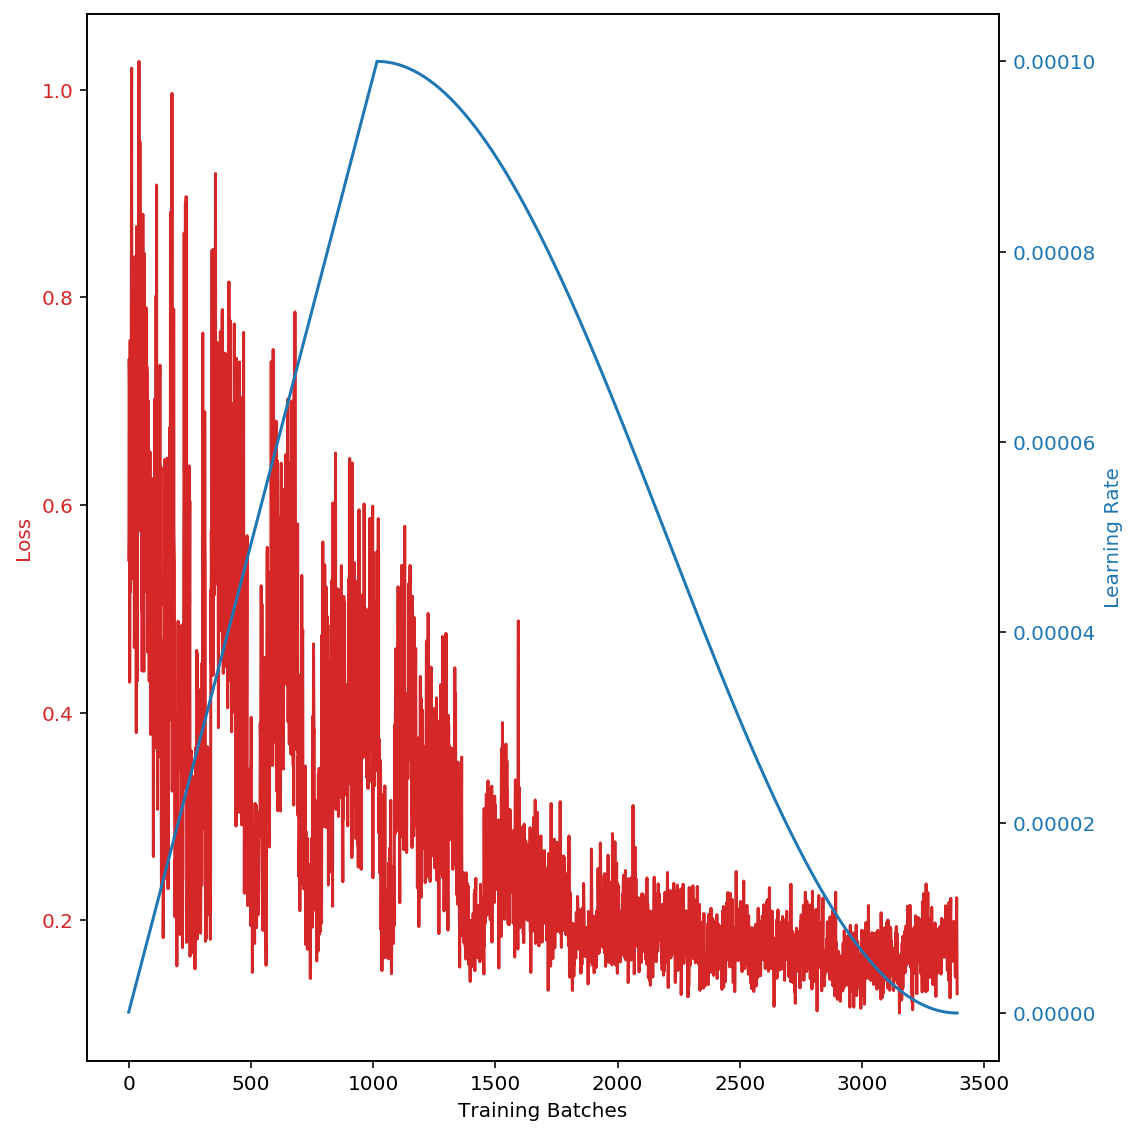

train   val
mean_or_std metric               
mean        map       0.652 0.610
            accuracy  0.657 0.619
            auc       0.763 0.723
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                      
    precision recall    f1  supoort precision recall    f1  supoort
neg     0.828  0.578 0.681 4560.000     0.787  0.546 0.645 1140.000
pos     0.521  0.792 0.628 2640.000     0.487  0.745 0.589  660.000

In [5]:
model_fn = model_builder(
    MultiImageMultiTextAttentionEarlyFusionModel,
    dict(
        image_models=[
            {
                "model": 'caption_features',
                "gaussian_noise": 0.0,
                "dropout": 0.0
            },
#             {
#                 "model": 'vgg_face',
#                 "gaussian_noise": 0.0,
#                 "dropout": 0.0,
#                 "finetune": True,
#             },
            {
                "model": 'detr_resnet50',
                "gaussian_noise": 0.0,
                "dropout": 0.0
            },
            {
                "model": 'detr_resnet50_panoptic',
                "gaussian_noise": 0.0,
                "dropout": 0.0
            },
            {
                "model": "torchvision_resnet18_ssl",
                "large_rf": True,
                "finetune": False
            },
        ],
        num_classes=2,
        text_models=[
            dict(cls=Fasttext1DCNNModel,
                 params=dict(
                     classifier_dims=256,
                     num_classes=2,
                     n_tokens_in=64,
                     n_tokens_out=16,
                     n_layers=2,
                     final_layer_builder=lambda *args: None,
                     gaussian_noise=0.5,
                     dropout=0.4,
                     embedding_dims=256,
                     internal_dims=256,
                     featurizer="gru",
                 ),
                 in_channels=256,
                 in_tokens=64,
                 forward="get_word_vectors"),
            dict(
                cls=AlbertClassifer,
                params=dict(classifier_dims=256,
                              num_classes=2,
                              embedding_dims=768,
                              gaussian_noise=0.1,
                              dropout=0.1,
                              internal_dims=512,
                              final_layer_builder=lambda *args: None,
                              n_layers=2,
                              n_encoders=2,
                              n_decoders=2,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilroberta-base',
                              finetune=False),
                in_channels=768,
                in_tokens=96,
                forward="get_word_vectors",
            )
        ],
        internal_dims=256,
        classifier_dims=256,
        n_tokens_out=32,
        n_layers=2, n_encoders=2, n_decoders=2,
        final_layer_builder=fb_1d_loss_builder,
        gaussian_noise=0.75,
        dropout=0.3,
    ),
    per_param_opts_fn=None,
    optimiser_class=optimizer,
    optimiser_params=optimizer_params)

data["metadata"]["use_images"] = True
batch_size = 64
epochs = 30
multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 20, 23, 27], show_model_stats=False)
r1, p1 = results, prfs
results
prfs

# "detr_demo", 'detr_resnet50', 'detr_resnet50_panoptic', 'detr_resnet101', 'detr_resnet101_panoptic', "caption_features"

# Predict

In [ ]:
batch_size=512
epochs = 1

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, augmentation_weights, scheduler_init_fn=scheduler_init_fn)
submission.to_csv("submission.csv",index=False)
submission.sample(3)


In [ ]:
submission.sample(10)